In [2]:
import numpy as np
from typing import Optional, Tuple, List
from itertools import combinations

class THAIDNode:
    """Node in a THAID tree."""
    __slots__ = ('prediction', 'score', 'n_samples', 'class_counts',
                 'split_feature_idx', 'split_value', 'split_categories',
                 'is_numeric', 'left', 'right', 'is_leaf')

    def __init__(self):
        self.prediction = -1
        self.score = 0.0  # Stores theta (accuracy) or delta depending on context
        self.n_samples = 0
        self.class_counts = None
        self.split_feature_idx = -1
        self.split_value = None
        self.split_categories = None
        self.is_numeric = False
        self.left = None
        self.right = None
        self.is_leaf = True

class THAID:
    """
    THAID (Theta Automatic Interaction Detection) classifier.

    Parameters
    ----------
    criterion : {'theta', 'delta'}, default='theta'
        The splitting criterion to use.
        - 'theta': Maximizes the sum of modal frequencies (classification accuracy).
        - 'delta': Maximizes the distributional difference between child nodes.
    min_samples_split : int, default=20
        Minimum samples required to split a node
    min_samples_leaf : int, default=1
        Minimum samples required in a leaf
    max_depth : int, optional
        Maximum tree depth
    max_categories : int, default=10
        Max categories for exhaustive search. If categories > max_categories,
        a heuristic search (sorting by majority class probability) is used.
    """

    def __init__(
        self,
        criterion: str = 'theta',
        min_samples_split: int = 20,
        min_samples_leaf: int = 1,
        max_depth: Optional[int] = None,
        max_categories: int = 10
    ):
        if criterion not in ('theta', 'delta'):
            raise ValueError("Criterion must be 'theta' or 'delta'")

        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_categories = max_categories

        self.root_ = None
        self.n_features_ = 0
        self.n_classes_ = 0
        self.classes_ = None
        self.feature_types_ = None  # 0=numeric, 1=categorical
        self.feature_names_ = None

        self._X = None
        self._y = None
        self._sorted_indices = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fit the THAID tree."""
        X, y = self._validate_input(X, y)

        self.classes_, y_encoded = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]

        self._detect_feature_types(X)
        self._X = X
        self._y = y_encoded
        self._presort_numeric_features()

        indices = np.arange(len(y))
        self.root_ = self._build_tree(indices, depth=0)

        return self

    def _validate_input(self, X, y):
        """Convert inputs to numpy arrays."""
        if hasattr(X, 'values'):
            self.feature_names_ = list(X.columns)
            X = X.values
        else:
            X = np.asarray(X)
            self.feature_names_ = [f"X{i}" for i in range(X.shape[1])]

        y = y.values if hasattr(y, 'values') else np.asarray(y)

        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Shape mismatch: X has {X.shape[0]} samples, y has {y.shape[0]}")

        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            raise ValueError("X contains NaN or Inf")

        return X, y

    def _detect_feature_types(self, X):
        """Detect numeric (0) or categorical (1) features."""
        self.feature_types_ = np.zeros(self.n_features_, dtype=np.int8)

        for i in range(self.n_features_):
            col = X[:, i]
            if not np.issubdtype(col.dtype, np.number):
                self.feature_types_[i] = 1
                continue

            unique_vals = np.unique(col)
            if len(unique_vals) <= 10 and np.allclose(col, np.round(col)):
                self.feature_types_[i] = 1

    def _presort_numeric_features(self):
        """Pre-sort indices for numeric features."""
        self._sorted_indices = []
        for i in range(self.n_features_):
            if self.feature_types_[i] == 0:
                self._sorted_indices.append(np.argsort(self._X[:, i]))
            else:
                self._sorted_indices.append(None)

    def _calculate_split_score(self, left_counts, right_counts, n_total):
        """Calculate the score for a split based on the selected criterion."""
        if self.criterion == 'theta':
            # Theta: Maximize accuracy (modal frequency)
            return (np.max(left_counts) + np.max(right_counts)) / n_total

        elif self.criterion == 'delta':
            # Delta: Maximize distributional difference
            n_left = np.sum(left_counts)
            n_right = np.sum(right_counts)

            if n_left == 0 or n_right == 0:
                return 0.0

            p_left = left_counts / n_left
            p_right = right_counts / n_right

            # L1 distance (Sum of absolute differences)
            return np.sum(np.abs(p_left - p_right))

        return 0.0

    def _build_tree(self, indices, depth):
        """Build tree recursively."""
        node = THAIDNode()
        node.n_samples = len(indices)

        y_subset = self._y[indices]
        node.class_counts = np.bincount(y_subset, minlength=self.n_classes_)

        node.prediction = np.argmax(node.class_counts)
        # Display score is always accuracy (theta) for readability
        node.score = node.class_counts[node.prediction] / node.n_samples

        if self._should_stop(node, depth):
            return node

        best_split = self._find_best_split(indices)

        if best_split is None:
            return node

        feature_idx, split_info, _, left_idx, right_idx = best_split

        if len(left_idx) < self.min_samples_leaf or len(right_idx) < self.min_samples_leaf:
            return node

        node.is_leaf = False
        node.split_feature_idx = feature_idx

        if self.feature_types_[feature_idx] == 0:
            node.is_numeric = True
            node.split_value = split_info
        else:
            node.is_numeric = False
            node.split_categories = split_info

        node.left = self._build_tree(left_idx, depth + 1)
        node.right = self._build_tree(right_idx, depth + 1)

        return node

    def _should_stop(self, node, depth):
        """Check stopping conditions."""
        if np.count_nonzero(node.class_counts) <= 1:
            return True
        if node.n_samples < self.min_samples_split:
            return True
        if self.max_depth is not None and depth >= self.max_depth:
            return True
        return False

    def _find_best_split(self, indices):
        """Find best split across all features."""
        best_score = -1.0
        best_result = None

        for feature_idx in range(self.n_features_):
            if self.feature_types_[feature_idx] == 0:
                result = self._find_numeric_split(indices, feature_idx)
            else:
                result = self._find_categorical_split(indices, feature_idx)

            if result is not None and result[1] > best_score:
                best_score = result[1]
                best_result = (feature_idx,) + result

        return best_result

    def _find_numeric_split(self, indices, feature_idx):
        """Find best numeric split."""
        sorted_full = self._sorted_indices[feature_idx]
        mask = np.isin(sorted_full, indices, assume_unique=True)
        relevant = sorted_full[mask]

        if len(relevant) < 2:
            return None

        X_sorted = self._X[relevant, feature_idx]
        y_sorted = self._y[relevant]
        n_total = len(relevant)

        change_indices = np.where(X_sorted[:-1] != X_sorted[1:])[0]
        if len(change_indices) == 0:
            return None

        right_counts = np.bincount(y_sorted, minlength=self.n_classes_)
        left_counts = np.zeros(self.n_classes_, dtype=np.int64)

        best_score = -1.0
        best_split_val = None
        best_split_idx = None

        current_idx = 0
        for split_idx in change_indices:
            for i in range(current_idx, split_idx + 1):
                cls = y_sorted[i]
                left_counts[cls] += 1
                right_counts[cls] -= 1

            current_idx = split_idx + 1
            score = self._calculate_split_score(left_counts, right_counts, n_total)

            if score > best_score:
                best_score = score
                best_split_idx = split_idx
                best_split_val = (X_sorted[split_idx] + X_sorted[split_idx + 1]) / 2.0

        if best_split_val is None:
            return None

        left_mask = X_sorted <= X_sorted[best_split_idx]
        left_indices = indices[np.isin(indices, relevant[left_mask])]
        right_indices = indices[np.isin(indices, relevant[~left_mask])]

        return best_split_val, best_score, left_indices, right_indices

    def _find_categorical_split(self, indices, feature_idx):
        """Find best categorical split using Exhaustive OR Heuristic search."""
        X_col = self._X[indices, feature_idx]
        unique_vals = np.unique(X_col)

        if len(unique_vals) < 2:
            return None

        # Decision: Exhaustive vs Heuristic
        if len(unique_vals) <= self.max_categories:
            return self._exhaustive_categorical(indices, feature_idx, unique_vals)
        else:
            return self._heuristic_categorical(indices, feature_idx, unique_vals)

    def _exhaustive_categorical(self, indices, feature_idx, unique_vals):
        """Exhaustive search over category subsets O(2^C)."""
        X_col = self._X[indices, feature_idx]
        y_subset = self._y[indices]
        n_total = len(indices)

        best_score = -1.0
        best_mask = None

        max_size = (len(unique_vals) // 2) + 1

        for size in range(1, max_size):
            for combo in combinations(unique_vals, size):
                mask = np.isin(X_col, combo)

                if not np.any(mask) or np.all(mask):
                    continue

                y_left = y_subset[mask]
                y_right = y_subset[~mask]

                counts_left = np.bincount(y_left, minlength=self.n_classes_)
                counts_right = np.bincount(y_right, minlength=self.n_classes_)

                score = self._calculate_split_score(counts_left, counts_right, n_total)

                if score > best_score:
                    best_score = score
                    best_mask = mask.copy()

        if best_mask is None:
            return None

        return best_mask, best_score, indices[best_mask], indices[~best_mask]

    def _heuristic_categorical(self, indices, feature_idx, unique_vals):
        """
        Heuristic search for high-cardinality features O(C log C).
        Sorts categories by the proportion of the majority class, then
        treats them as ordinal values to find the best split point.
        """
        X_col = self._X[indices, feature_idx]
        y_subset = self._y[indices]
        n_total = len(indices)

        # 1. Determine Majority Class of current node
        majority_class = np.argmax(np.bincount(y_subset, minlength=self.n_classes_))

        # 2. Score each category based on how often it predicts the majority class
        # (This orders categories by probability P(Class=Majority | Category))
        cat_scores = []
        for cat in unique_vals:
            mask = (X_col == cat)
            if not np.any(mask):
                continue
            # Fraction of this category that belongs to the majority class
            prob = np.mean(y_subset[mask] == majority_class)
            cat_scores.append((cat, prob))

        # 3. Sort categories by that probability
        cat_scores.sort(key=lambda x: -x[1]) # Descending order
        sorted_cats = [x[0] for x in cat_scores]

        # 4. Iterate through split points in the sorted list (like numerical split)
        best_score = -1.0
        best_mask = None

        # We accumulate counts to avoid re-scanning data every time (Optimization)
        # Note: Ideally we'd use cumulative sums, but for clarity/simplicity we'll regenerate masks
        # Since we are already in heuristic mode, slight inefficiency here is acceptable vs 2^N

        for i in range(1, len(sorted_cats)):
            # Split: Left = Top i categories, Right = Rest
            current_left_cats = sorted_cats[:i]
            mask = np.isin(X_col, current_left_cats)

            if not np.any(mask) or np.all(mask):
                continue

            y_left = y_subset[mask]
            y_right = y_subset[~mask]

            counts_left = np.bincount(y_left, minlength=self.n_classes_)
            counts_right = np.bincount(y_right, minlength=self.n_classes_)

            score = self._calculate_split_score(counts_left, counts_right, n_total)

            if score > best_score:
                best_score = score
                best_mask = mask.copy()

        if best_mask is None:
            return None

        return best_mask, best_score, indices[best_mask], indices[~best_mask]

    def predict(self, X):
        """Predict class labels."""
        if self.root_ is None:
            raise ValueError("Model not fitted")

        X = X.values if hasattr(X, 'values') else np.asarray(X)

        predictions = np.empty(len(X), dtype=np.int64)
        self._predict_recursive(self.root_, X, np.arange(len(X)), predictions)

        return self.classes_[predictions]

    def _predict_recursive(self, node, X, indices, results):
        """Recursively predict."""
        if len(indices) == 0:
            return

        if node.is_leaf:
            results[indices] = node.prediction
            return

        X_feature = X[indices, node.split_feature_idx]

        if node.is_numeric:
            goes_left = X_feature <= node.split_value
        else:
            goes_left = np.isin(X_feature, node.split_categories)

        self._predict_recursive(node.left, X, indices[goes_left], results)
        self._predict_recursive(node.right, X, indices[~goes_left], results)

    def predict_proba(self, X):
        """Predict class probabilities."""
        if self.root_ is None:
            raise ValueError("Model not fitted")

        X = X.values if hasattr(X, 'values') else np.asarray(X)

        probas = np.zeros((len(X), self.n_classes_))
        self._predict_proba_recursive(self.root_, X, np.arange(len(X)), probas)

        return probas

    def _predict_proba_recursive(self, node, X, indices, results):
        """Recursively predict probabilities."""
        if len(indices) == 0:
            return

        if node.is_leaf:
            results[indices] = node.class_counts / node.n_samples
            return

        X_feature = X[indices, node.split_feature_idx]

        if node.is_numeric:
            goes_left = X_feature <= node.split_value
        else:
            goes_left = np.isin(X_feature, node.split_categories)

        self._predict_proba_recursive(node.left, X, indices[goes_left], results)
        self._predict_proba_recursive(node.right, X, indices[~goes_left], results)

    def score(self, X, y):
        """Calculate accuracy."""
        y = y.values if hasattr(y, 'values') else y
        return np.mean(self.predict(X) == y)

    def print_tree(self, max_depth=None):
        """Print tree structure."""
        if self.root_ is None:
            print("Model not fitted")
            return

        def print_node(node, depth=0):
            if max_depth is not None and depth > max_depth:
                return

            indent = "  " * depth

            if node.is_leaf:
                print(f"{indent}Leaf: class={self.classes_[node.prediction]}, "
                      f"score={node.score:.3f}, n={node.n_samples}")
            else:
                fname = self.feature_names_[node.split_feature_idx]

                if node.is_numeric:
                    print(f"{indent}{fname} <= {node.split_value:.3f} "
                          f"(score={node.score:.3f}, n={node.n_samples})")
                else:
                    print(f"{indent}{fname} in {list(node.split_categories)[:5]} "
                          f"(score={node.score:.3f}, n={node.n_samples})")

                print_node(node.left, depth + 1)
                print_node(node.right, depth + 1)

        print(f"Splitting Criterion: {self.criterion.upper()}")
        print_node(self.root_)

DEMO 1: Basic Usage with Synthetic Binary Classification

--- Training with THETA criterion (maximize accuracy) ---

Test Accuracy (Theta): 0.9133

Tree Structure (Theta):
Splitting Criterion: THETA
X1 <= 0.079 (score=0.503, n=350)
  X0 <= 1.030 (score=0.849, n=186)
    Leaf: class=0, score=0.918, n=171
    Leaf: class=1, score=0.933, n=15
  Leaf: class=1, score=0.902, n=164


--- Training with DELTA criterion (maximize class separation) ---

Test Accuracy (Delta): 0.9133

Tree Structure (Delta):
Splitting Criterion: DELTA
X1 <= 0.098 (score=0.503, n=350)
  X0 <= 1.220 (score=0.846, n=188)
    Leaf: class=0, score=0.914, n=174
    Leaf: class=1, score=1.000, n=14
  Leaf: class=1, score=0.907, n=162


DEMO 2: Iris Dataset (Multi-class Classification)

Theta Accuracy: 0.9333
Delta Accuracy: 0.9333

--- Classification Report (Theta) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.80      0.89  

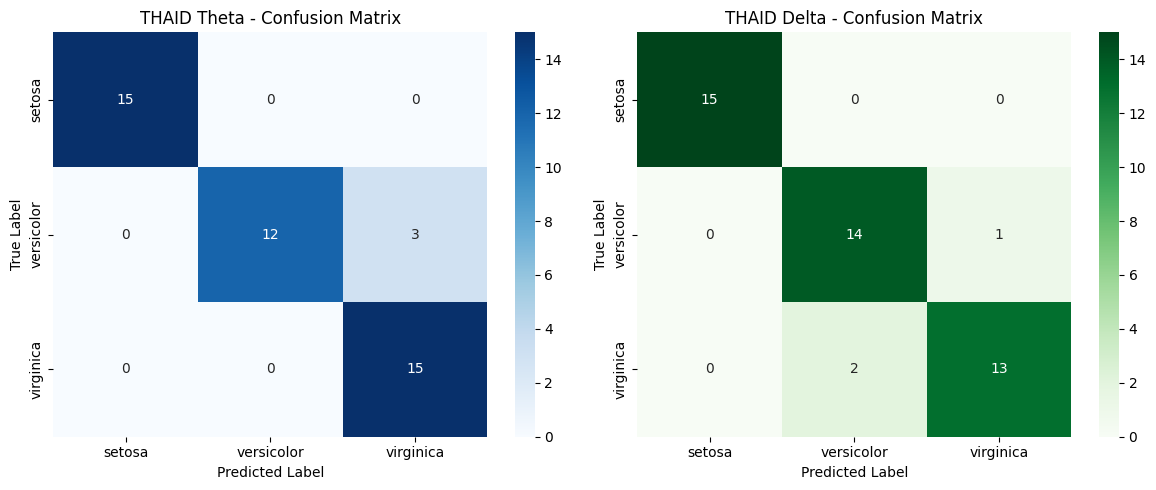


COMPARISON: Tree Depth vs Accuracy


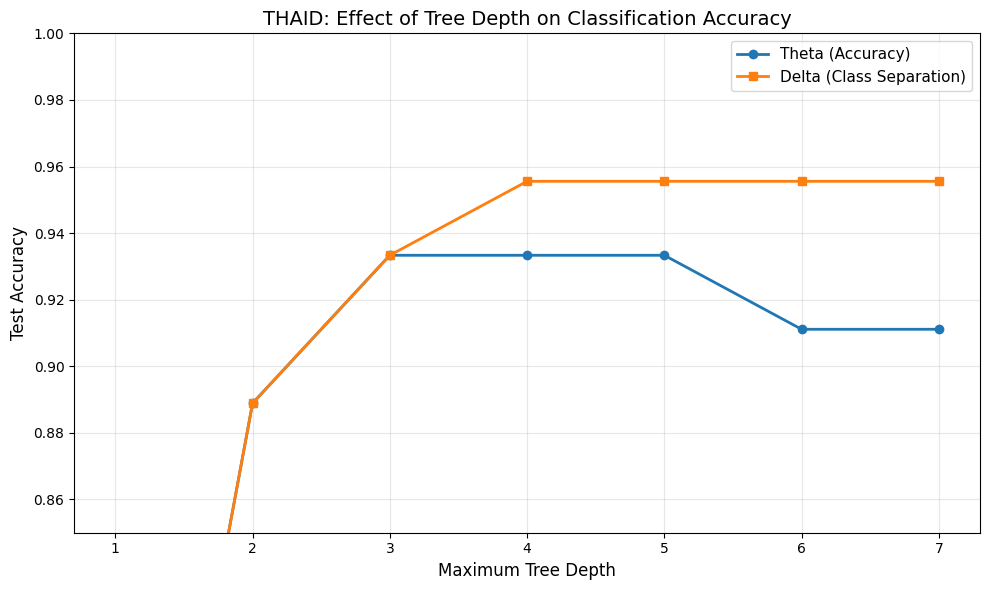


Depth vs Accuracy Results:
   Depth   Theta   Delta
0      1  0.6667  0.6667
1      2  0.8889  0.8889
2      3  0.9333  0.9333
3      4  0.9333  0.9556
4      5  0.9333  0.9556
5      6  0.9111  0.9556
6      7  0.9111  0.9556


DEMO 5: High Cardinality Categorical Feature (Heuristic)

Dataset has 50 unique categories
Model uses heuristic search (max_categories=10)
Training Accuracy: 0.7860


In [6]:
# ============================================================================
# THAID Classifier Demo
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_iris, load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# Demo 1: Basic Usage with Synthetic Data
# ============================================================================

print("="*80)
print("DEMO 1: Basic Usage with Synthetic Binary Classification")
print("="*80)

# Generate synthetic dataset
X_syn, y_syn = make_classification(
    n_samples=500,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_clusters_per_class=2,
    n_classes=2,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_syn, y_syn, test_size=0.3, random_state=42
)

# Train with THETA criterion
print("\n--- Training with THETA criterion (maximize accuracy) ---")
thaid_theta = THAID(
    criterion='theta',
    min_samples_split=20,
    min_samples_leaf=5,
    max_depth=4
)
thaid_theta.fit(X_train, y_train)

# Predictions
y_pred_theta = thaid_theta.predict(X_test)
accuracy_theta = accuracy_score(y_test, y_pred_theta)

print(f"\nTest Accuracy (Theta): {accuracy_theta:.4f}")
print("\nTree Structure (Theta):")
thaid_theta.print_tree(max_depth=2)

# Train with DELTA criterion
print("\n\n--- Training with DELTA criterion (maximize class separation) ---")
thaid_delta = THAID(
    criterion='delta',
    min_samples_split=20,
    min_samples_leaf=5,
    max_depth=4
)
thaid_delta.fit(X_train, y_train)

# Predictions
y_pred_delta = thaid_delta.predict(X_test)
accuracy_delta = accuracy_score(y_test, y_pred_delta)

print(f"\nTest Accuracy (Delta): {accuracy_delta:.4f}")
print("\nTree Structure (Delta):")
thaid_delta.print_tree(max_depth=2)

# Real Dataset - Iris (Multi-class)

print("\n\n" + "="*80)
print("DEMO 2: Iris Dataset (Multi-class Classification)")
print("="*80)

# Load iris dataset
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

# Split
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

# Train both models
thaid_iris_theta = THAID(criterion='theta', max_depth=3)
thaid_iris_theta.fit(X_train_iris, y_train_iris)

thaid_iris_delta = THAID(criterion='delta', max_depth=3)
thaid_iris_delta.fit(X_train_iris, y_train_iris)

# Evaluate
y_pred_iris_theta = thaid_iris_theta.predict(X_test_iris)
y_pred_iris_delta = thaid_iris_delta.predict(X_test_iris)

print(f"\nTheta Accuracy: {accuracy_score(y_test_iris, y_pred_iris_theta):.4f}")
print(f"Delta Accuracy: {accuracy_score(y_test_iris, y_pred_iris_delta):.4f}")

print("\n--- Classification Report (Theta) ---")
print(classification_report(y_test_iris, y_pred_iris_theta,
                          target_names=iris.target_names))


# Categorical Features (encoded as integers)


print("\n" + "="*80)
print("DEMO 3: Categorical Features (Integer-Encoded)")
print("="*80)

# Create a dataset with categorical features
n_samples = 300
np.random.seed(42)

# Categorical features (encoded as integers 0, 1, 2)
colors = np.random.choice([0, 1, 2], size=n_samples)  # 0=red, 1=blue, 2=green
sizes = np.random.choice([0, 1, 2], size=n_samples)   # 0=small, 1=medium, 2=large

# Numeric features
age = np.random.randint(18, 70, size=n_samples)
income = np.random.normal(50000, 15000, size=n_samples)

# Target: based on rules involving both numeric and categorical
y_mixed = np.zeros(n_samples)
for i in range(n_samples):
    if colors[i] == 0 and age[i] > 40:  # red and older
        y_mixed[i] = 1
    elif sizes[i] == 2 and income[i] > 55000:  # large and high income
        y_mixed[i] = 1
    elif colors[i] == 1 and sizes[i] == 0:  # blue and small
        y_mixed[i] = 0
    else:
        y_mixed[i] = np.random.choice([0, 1])


X_mixed = pd.DataFrame({
    'color': colors,
    'size': sizes,
    'age': age,
    'income': income
})

# Split
X_train_mix, X_test_mix, y_train_mix, y_test_mix = train_test_split(
    X_mixed, y_mixed, test_size=0.3, random_state=42
)

# Train
thaid_mixed = THAID(criterion='theta', max_depth=4, min_samples_split=15)
thaid_mixed.fit(X_train_mix, y_train_mix)

# Predict
y_pred_mix = thaid_mixed.predict(X_test_mix)

print(f"\nAccuracy on Mixed Data: {accuracy_score(y_test_mix, y_pred_mix):.4f}")
print("\nNote: color (0=red, 1=blue, 2=green), size (0=small, 1=medium, 2=large)")
print("\nTree Structure (showing categorical splits):")
thaid_mixed.print_tree(max_depth=3)


# Probability Predictions


print("\n\n" + "="*80)
print("DEMO 4: Probability Predictions")
print("="*80)

# Use iris dataset for probability demo
probas_theta = thaid_iris_theta.predict_proba(X_test_iris)
probas_delta = thaid_iris_delta.predict_proba(X_test_iris)

print("\nProbability predictions for first 5 test samples (Theta):")
print(pd.DataFrame(
    probas_theta[:5],
    columns=[f"Class_{i}" for i in range(3)]
).round(3))

print("\nProbability predictions for first 5 test samples (Delta):")
print(pd.DataFrame(
    probas_delta[:5],
    columns=[f"Class_{i}" for i in range(3)]
).round(3))


print("\n\n" + "="*80)
print("VISUALIZATION: Confusion Matrices")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Theta confusion matrix
cm_theta = confusion_matrix(y_test_iris, y_pred_iris_theta)
sns.heatmap(cm_theta, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            ax=axes[0])
axes[0].set_title('THAID Theta - Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Delta confusion matrix
cm_delta = confusion_matrix(y_test_iris, y_pred_iris_delta)
sns.heatmap(cm_delta, annot=True, fmt='d', cmap='Greens',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names,
            ax=axes[1])
axes[1].set_title('THAID Delta - Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Comparison: Depth vs Accuracy


print("\n" + "="*80)
print("COMPARISON: Tree Depth vs Accuracy")
print("="*80)

depths = range(1, 8)
theta_scores = []
delta_scores = []

for depth in depths:
    # Theta
    model_t = THAID(criterion='theta', max_depth=depth)
    model_t.fit(X_train_iris, y_train_iris)
    theta_scores.append(model_t.score(X_test_iris, y_test_iris))

    # Delta
    model_d = THAID(criterion='delta', max_depth=depth)
    model_d.fit(X_train_iris, y_train_iris)
    delta_scores.append(model_d.score(X_test_iris, y_test_iris))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(depths, theta_scores, marker='o', label='Theta (Accuracy)', linewidth=2)
plt.plot(depths, delta_scores, marker='s', label='Delta (Class Separation)', linewidth=2)
plt.xlabel('Maximum Tree Depth', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('THAID: Effect of Tree Depth on Classification Accuracy', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths)
plt.ylim([0.85, 1.0])
plt.tight_layout()
plt.show()

print("\nDepth vs Accuracy Results:")
results_df = pd.DataFrame({
    'Depth': depths,
    'Theta': theta_scores,
    'Delta': delta_scores
})
print(results_df.round(4))


# High Cardinality Categorical Features (Heuristic Search)


print("\n\n" + "="*80)
print("DEMO 5: High Cardinality Categorical Feature (Heuristic)")
print("="*80)

# Create dataset with high-cardinality categorical feature (as integers)
n_samples = 500
n_categories = 50  # More than max_categories=10, will trigger heuristic

# Generate categories as integers 0-49 (representing product IDs, zip codes, etc.)
categories = np.random.choice(range(n_categories), size=n_samples)
numeric_feature = np.random.randn(n_samples)

# Target based on category groups and numeric feature
y_high_card = np.zeros(n_samples)
for i in range(n_samples):
    cat_num = categories[i]
    if cat_num < 15 and numeric_feature[i] > 0:
        y_high_card[i] = 1
    elif cat_num >= 35 and numeric_feature[i] < 0:
        y_high_card[i] = 1

X_high_card = pd.DataFrame({
    'category': categories,
    'numeric': numeric_feature
})

# Train
thaid_heuristic = THAID(
    criterion='theta',
    max_depth=3,
    max_categories=10  # Forces heuristic for 50 categories
)
thaid_heuristic.fit(X_high_card, y_high_card)

print(f"\nDataset has {n_categories} unique categories")
print(f"Model uses heuristic search (max_categories={thaid_heuristic.max_categories})")
print(f"Training Accuracy: {thaid_heuristic.score(X_high_card, y_high_card):.4f}")
